In [2]:
import os 
import json
import sys 
sys.path.append(os.path.abspath("./scripts"))
from circuit_top_tools import *
from tools import * 

from sklearn.decomposition import IncrementalPCA
from scipy import sparse

In [5]:
# visualize PCA on the same principle components 
# "/wt_hiapp_apo/outdir_wt_hiapp_apo/ctop_model.npy",
# "/wt_hiapp_yxi1/outdir_wt_hiapp_yxi1/ctop_model.npy", 
# "/wt_hiapp_yxa1/outdir_wt_hiapp_yxa1/ctop_model.npy", 
file_paths = [
"/s20g_hiapp_apo/outdir_s20g_hiapp_apo/ctop_model.npy",
"/s20g_hiapp_yxi1/outdir_s20g_hiapp_yxi1/ctop_model.npy", 
"/s20g_hiapp_yxa1/outdir_s20g_hiapp_yxa1/ctop_model.npy"]

# transformer = IncrementalPCA(n_components=5, batch_size=200)
for fname in file_paths: 
    print("fitting the following filepath: ", fname)
    circuit_model = np.load(".." + fname)
    X_sparse = sparse.csr_matrix(circuit_model)
    X_transformed = transformer.fit(X_sparse)
    print("done fitting this batch")

fitting the following filepath:  /s20g_hiapp_apo/outdir_s20g_hiapp_apo/ctop_model.npy
done fitting this batch
fitting the following filepath:  /s20g_hiapp_yxi1/outdir_s20g_hiapp_yxi1/ctop_model.npy
done fitting this batch
fitting the following filepath:  /s20g_hiapp_yxa1/outdir_s20g_hiapp_yxa1/ctop_model.npy
done fitting this batch


In [6]:
# "/wt_hiapp_apo/outdir_wt_hiapp_apo/ctop_model.npy"
file_paths = ["/wt_hiapp_yxi1/outdir_wt_hiapp_yxi1/ctop_model.npy", 
"/wt_hiapp_yxa1/outdir_wt_hiapp_yxa1/ctop_model.npy", 
"/s20g_hiapp_apo/outdir_s20g_hiapp_apo/ctop_model.npy",
"/s20g_hiapp_yxi1/outdir_s20g_hiapp_yxi1/ctop_model.npy", 
"/s20g_hiapp_yxa1/outdir_s20g_hiapp_yxa1/ctop_model.npy"]
circuit_model = np.load(".." + "/wt_hiapp_apo/outdir_wt_hiapp_apo/ctop_model.npy")
X_sparse = sparse.csr_matrix(circuit_model)
X_transformed = transformer.transform(X_sparse)

for fname in file_paths: 
    circuit_model = np.load(".." + fname)
    X_sparse = sparse.csr_matrix(circuit_model)
    X_transformed = np.concatenate((X_transformed, transformer.transform(X_sparse)))

    

In [8]:
np.save("all_sys_concat_incpca.npy", X_transformed)

In [10]:
# wt apo, wt yxi1, wt yxa1, 
each_system_n_frames = [41501,43001,33723,35501, 35399, 35251 ]

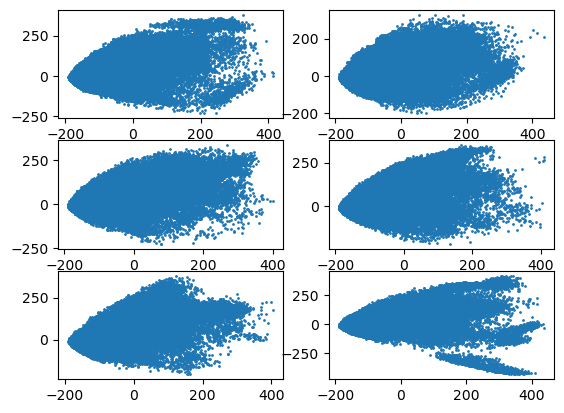

In [13]:
prev = 0 

fig, axes = plt.subplots(nrows=3, ncols=2)
for n_frames,ax in zip(each_system_n_frames, axes.flatten()): 
    x = X_transformed[:,0][prev:prev+n_frames]
    y = X_transformed[:,1][prev:prev+n_frames]
    ax.scatter(x,y,s=1)
    prev = prev+n_frames

4.998856477898592 8.235425843602503
5.237569087493317 8.235425843602503
5.3304057001307195 8.235425843602503
5.135031443883274 8.235425843602503
5.329297893046987 8.235425843602503
5.230903646638984 8.235425843602503


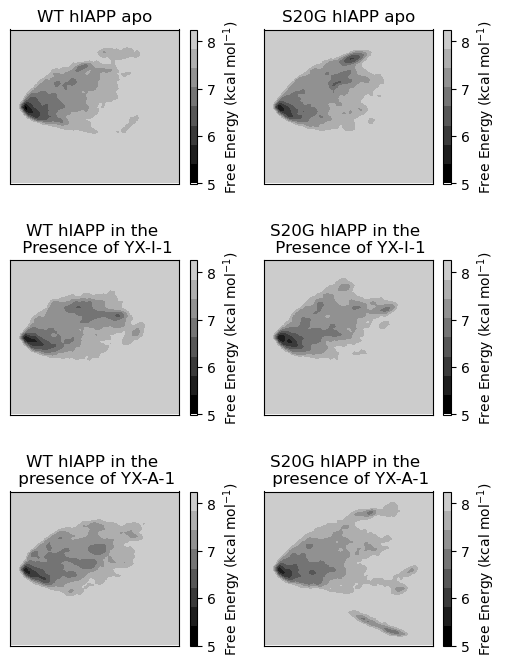

In [7]:
from matplotlib.colors import ListedColormap
# Create a list of distinct gray values
num_grays = 8
grays = np.linspace(0.0, 0.8, num_grays)
# Create a ListedColormap with distinct gray values
custom_pastel_gray_cmap = ListedColormap([(gray, gray, gray) for gray in grays])

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=[6,8])
Titles = ["WT hIAPP apo", "WT hIAPP in the \n Presence of YX-I-1", "WT hIAPP in the \n presence of YX-A-1", 
            "S20G hIAPP apo", "S20G hIAPP in the \n Presence of YX-I-1", "S20G hIAPP in the \n presence of YX-A-1"]

prev = 0 
count = 0 
col_count = 0 
for n_frames in each_system_n_frames: 
    if count >= 3: 
        col_count = 1
    
    ax = axes[count%3, col_count]
    x = X_transformed[:,0][prev:prev+n_frames]
    y = X_transformed[:,1][prev:prev+n_frames]
    counts,xbins,ybins=np.histogram2d(y,x,bins=50,normed=True, range=[[np.min(X_transformed[:,1])-50, np.max(X_transformed[:,1])+50], [np.min(X_transformed[:,0])-50, np.max(X_transformed[:,0])+50]]) # LogNorm()
    a = np.log(np.flipud(counts)+.000001)
    T = 300
    a = -(0.001987*T)*a

    print(np.min(a), np.max(a))
    im = ax.imshow(a, interpolation='gaussian', extent=[ybins[0], ybins[-1], 
                    xbins[0], xbins[-1]], cmap=custom_pastel_gray_cmap, aspect='auto',
                    vmin=5.0, vmax=8.25)
    ax.set_title(Titles[count])
    cbar = plt.colorbar(im, ax=ax, label='Free Energy (kcal mol$^{-1}$)')

    count += 1 
    ax.set_xticks([])
    ax.set_yticks([])
    prev = prev+n_frames
plt.subplots_adjust(hspace=0.5)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Function to evaluate KMeans with different cluster numbers
# Function to evaluate KMeans with different cluster numbers
def evaluate_kmeans(data, max_clusters=10):
    distortions = []
    silhouette_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    cluster_range = range(2, max_clusters + 1)

    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
        kmeans.fit(data)
        labels = kmeans.labels_

        # Calculate distortion (sum of squared distances to centroids)
        distortions.append(kmeans.inertia_)

        # Calculate silhouette score
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)

        # Calculate Calinski-Harabasz score
        ch_score = calinski_harabasz_score(data, labels)
        calinski_harabasz_scores.append(ch_score)

        # Calculate Davies-Bouldin score
        db_score = davies_bouldin_score(data, labels)
        davies_bouldin_scores.append(db_score)

    return cluster_range, distortions, silhouette_scores, calinski_harabasz_scores, davies_bouldin_scores

In [25]:
def plot_kmeans(cluster_range, distortions, silhouette_scores, calinski_harabasz_scores, davies_bouldin_scores):
    # Plot the elbow method
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(cluster_range, distortions, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.grid(True)

    # Plot the silhouette scores
    plt.subplot(2, 2, 2)
    plt.plot(cluster_range, silhouette_scores, marker='o', color='orange')
    plt.title('Silhouette Scores')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)

    # Plot the Calinski-Harabasz scores
    plt.subplot(2, 2, 3)
    plt.plot(cluster_range, calinski_harabasz_scores, marker='o', color='green')
    plt.title('Calinski-Harabasz Index')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.grid(True)

    # Plot the Davies-Bouldin scores
    plt.subplot(2, 2, 4)
    plt.plot(cluster_range, davies_bouldin_scores, marker='o', color='red')
    plt.title('Davies-Bouldin Index')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Identify the best number of clusters based on the three metrics
    best_n_clusters_silhouette = cluster_range[np.argmax(silhouette_scores)]
    best_n_clusters_ch = cluster_range[np.argmax(calinski_harabasz_scores)]
    best_n_clusters_db = cluster_range[np.argmin(davies_bouldin_scores)]

    print(f"The best number of clusters based on Silhouette Score is: {best_n_clusters_silhouette}")
    print(f"The best number of clusters based on Calinski-Harabasz Index is: {best_n_clusters_ch}")
    print(f"The best number of clusters based on Davies-Bouldin Index is: {best_n_clusters_db}")

(41501, 5)


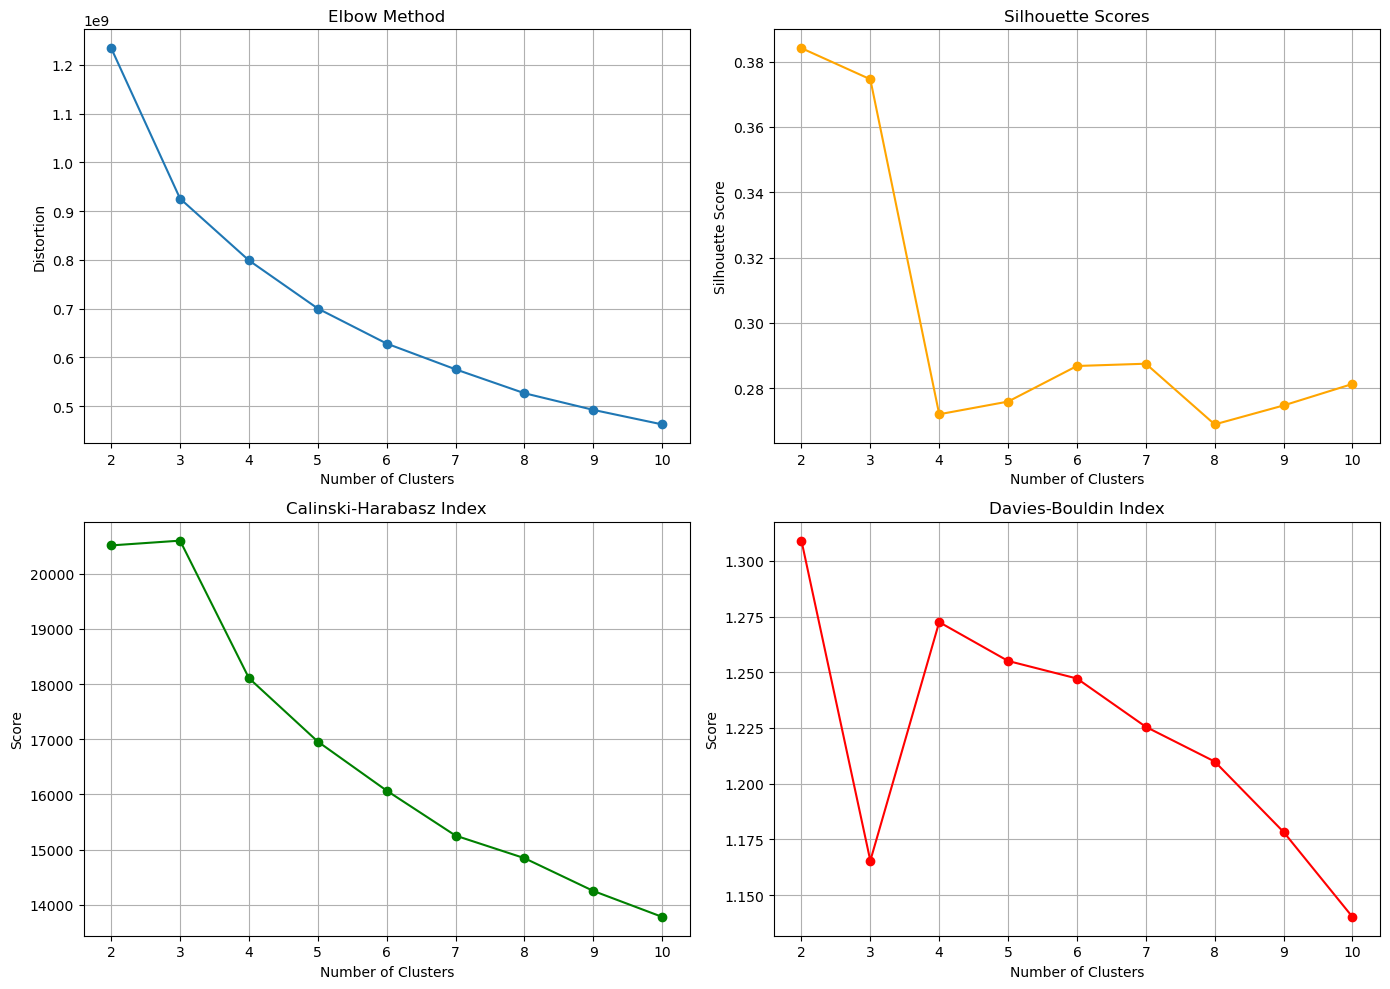

The best number of clusters based on Silhouette Score is: 2
The best number of clusters based on Calinski-Harabasz Index is: 3
The best number of clusters based on Davies-Bouldin Index is: 10
(43001, 5)


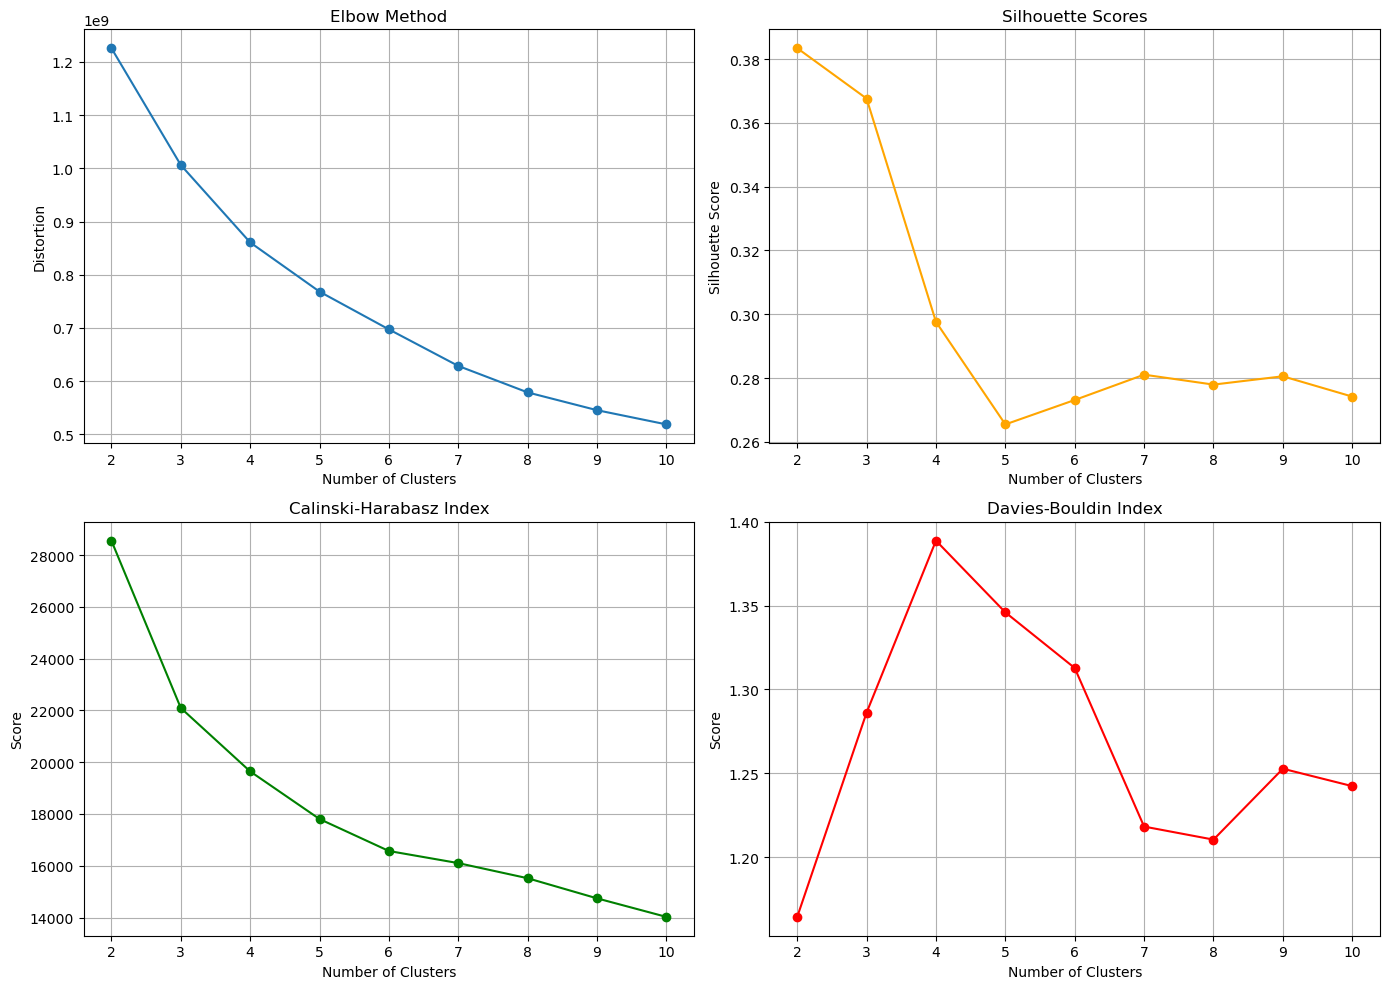

The best number of clusters based on Silhouette Score is: 2
The best number of clusters based on Calinski-Harabasz Index is: 2
The best number of clusters based on Davies-Bouldin Index is: 2
(33723, 5)


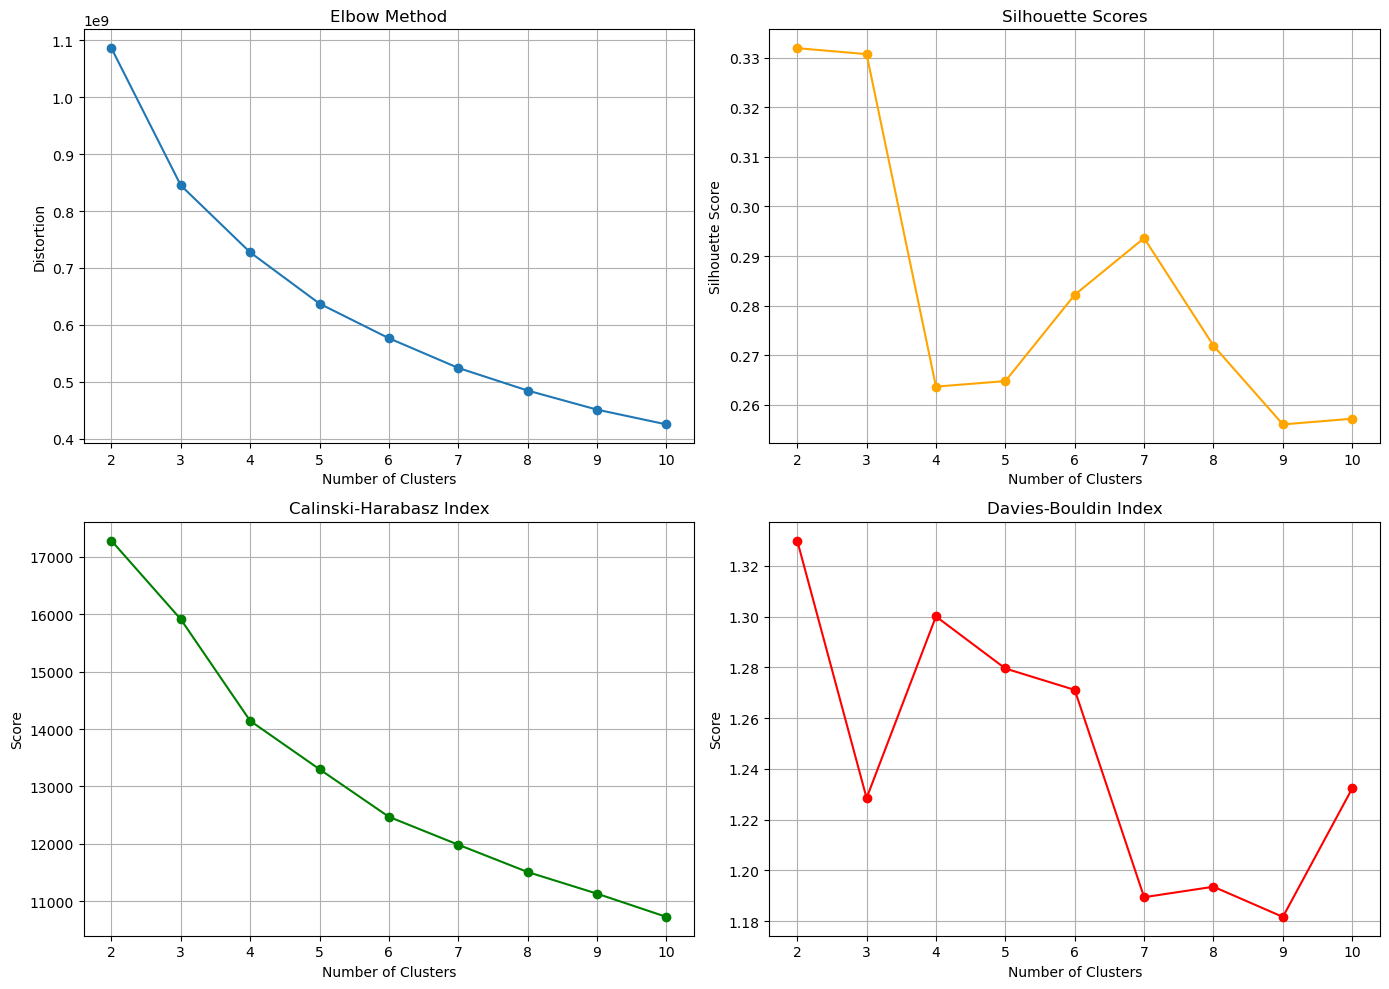

The best number of clusters based on Silhouette Score is: 2
The best number of clusters based on Calinski-Harabasz Index is: 2
The best number of clusters based on Davies-Bouldin Index is: 9
(35501, 5)


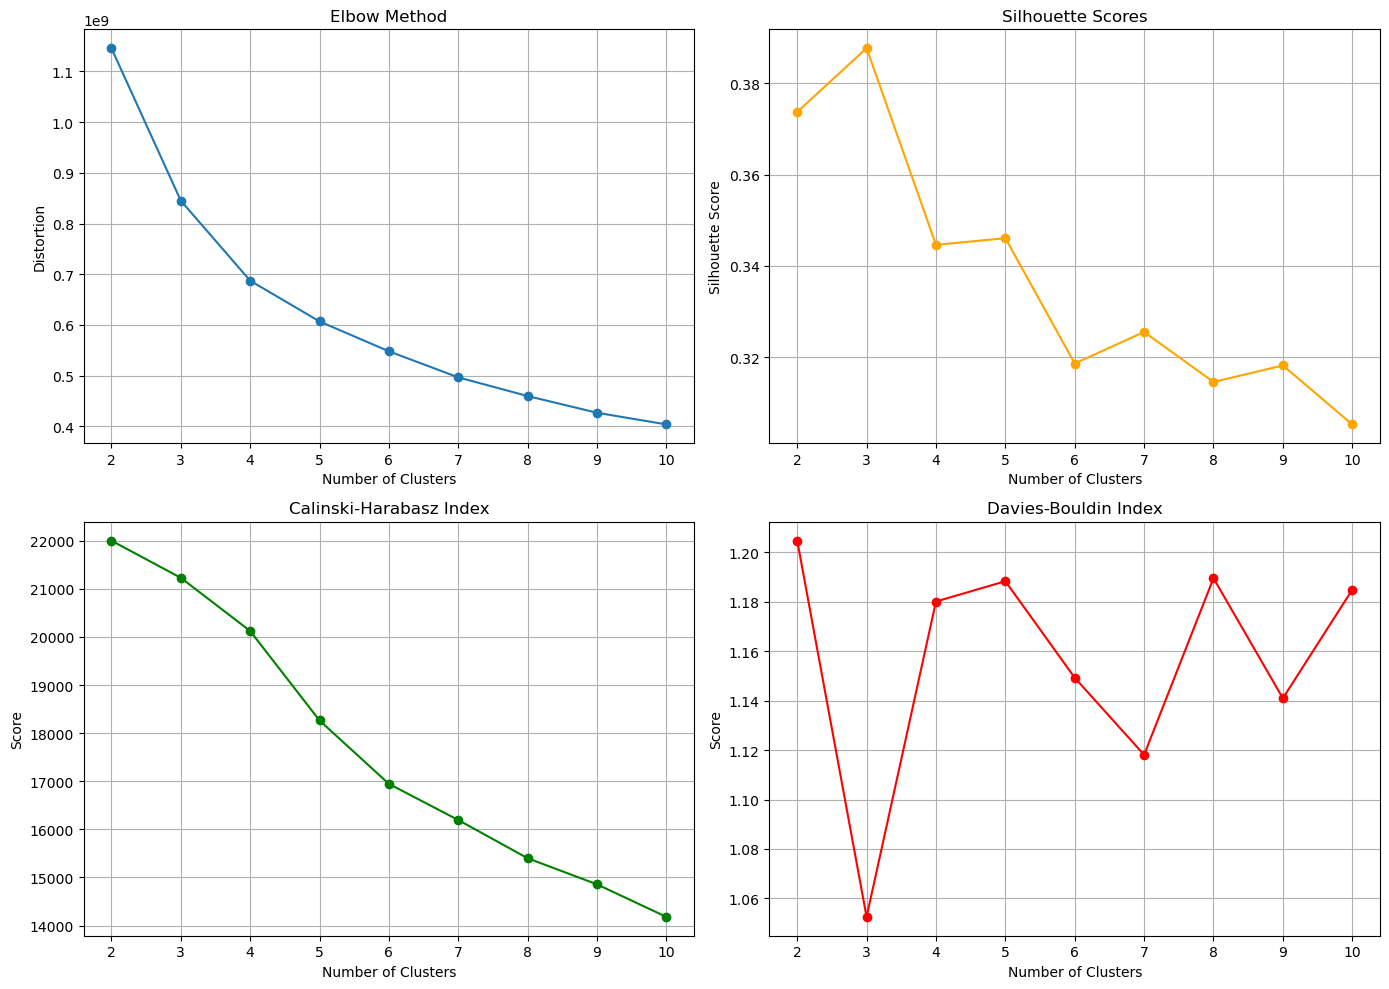

The best number of clusters based on Silhouette Score is: 3
The best number of clusters based on Calinski-Harabasz Index is: 2
The best number of clusters based on Davies-Bouldin Index is: 3
(35399, 5)


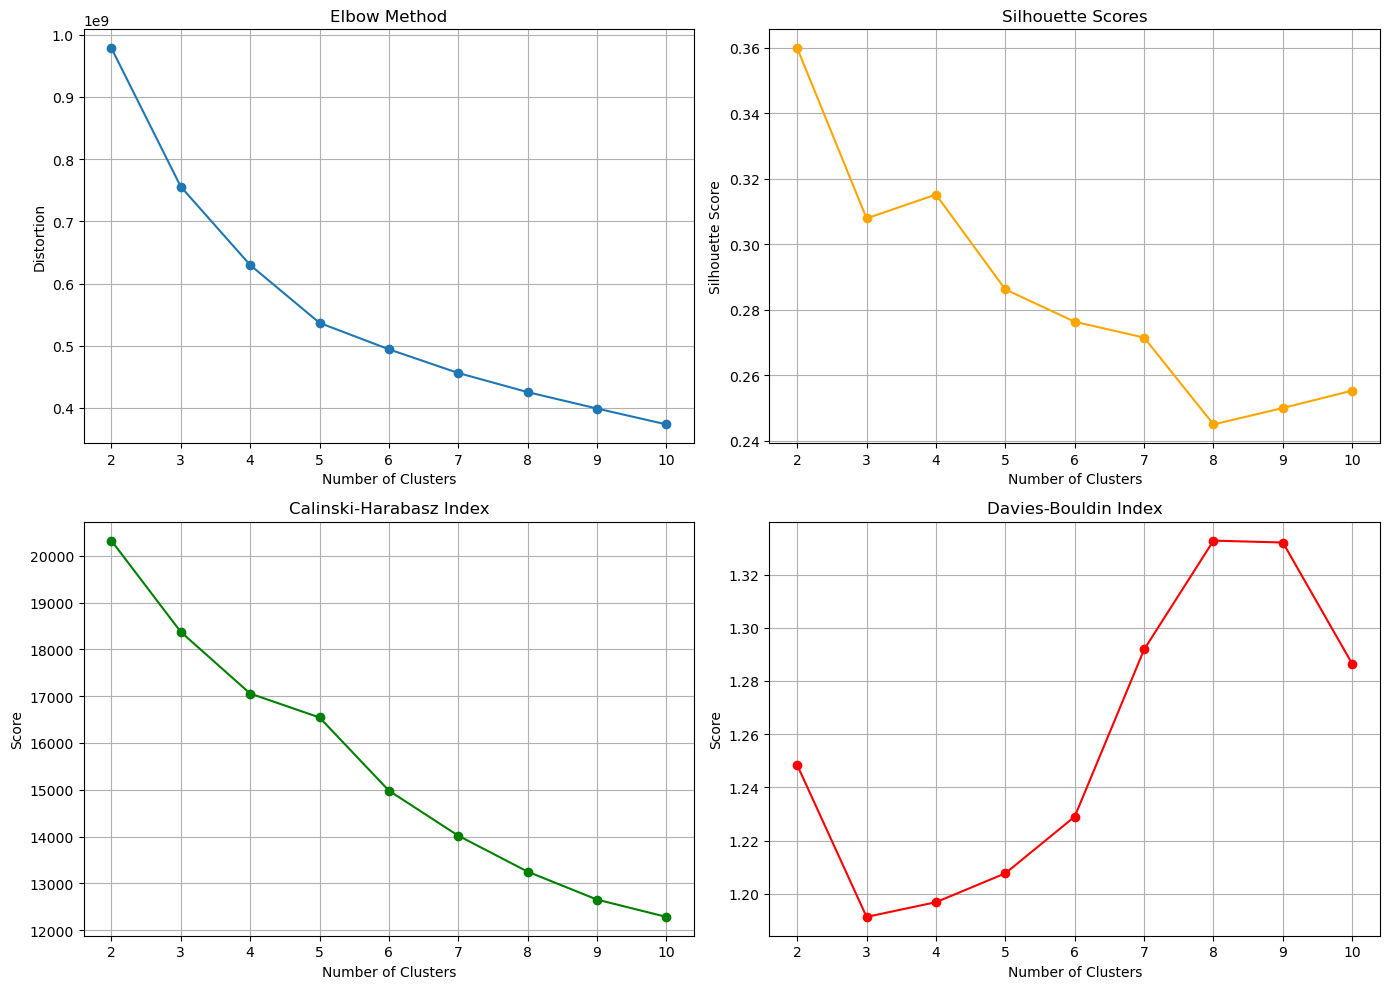

The best number of clusters based on Silhouette Score is: 2
The best number of clusters based on Calinski-Harabasz Index is: 2
The best number of clusters based on Davies-Bouldin Index is: 3
(35251, 5)


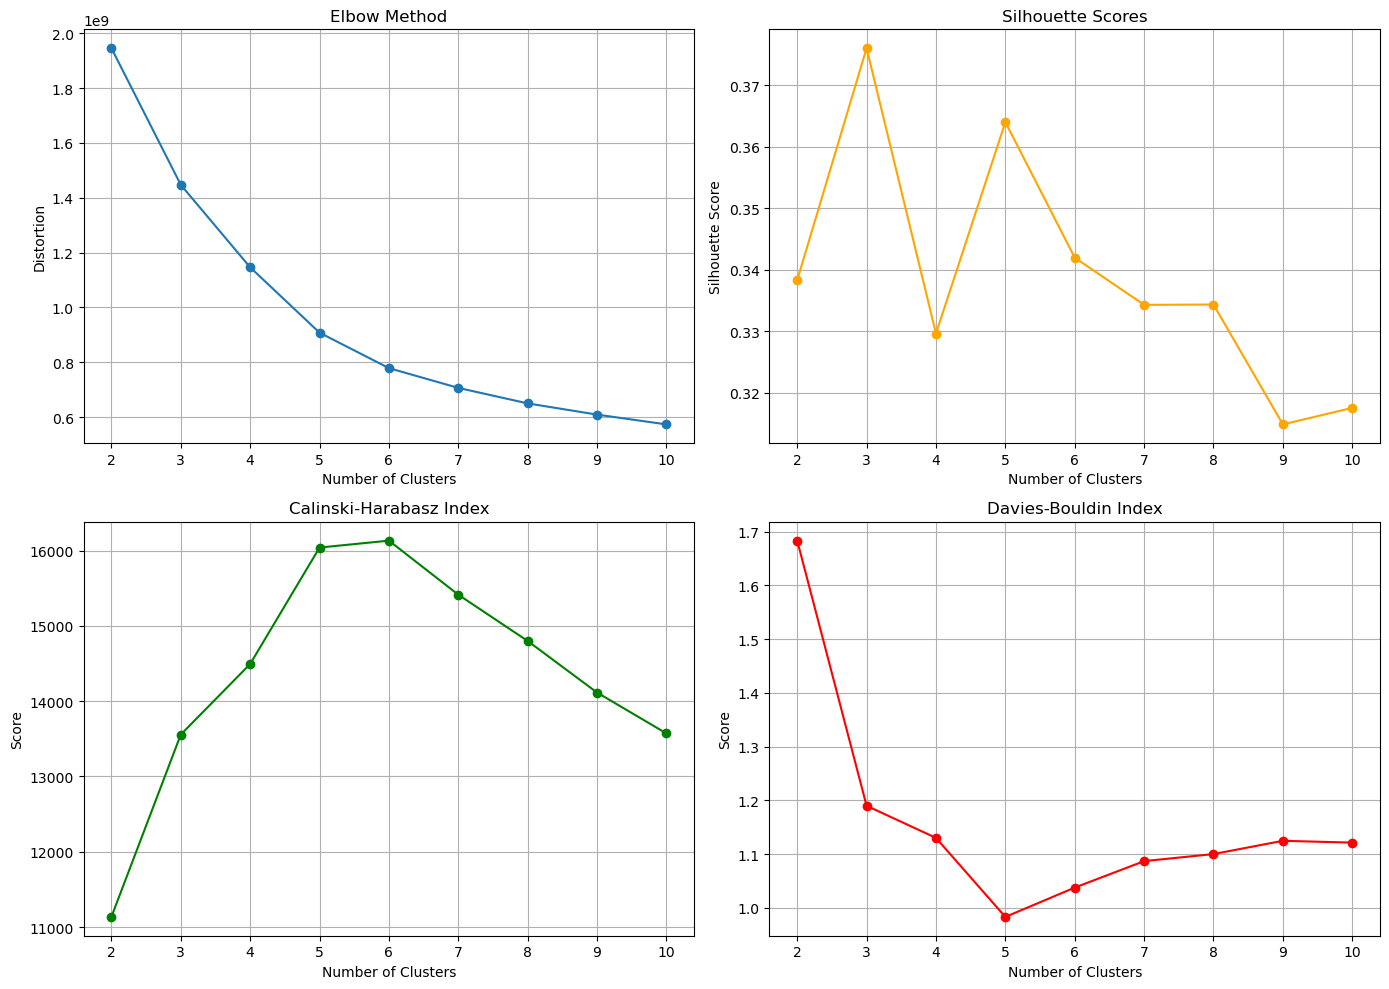

The best number of clusters based on Silhouette Score is: 3
The best number of clusters based on Calinski-Harabasz Index is: 6
The best number of clusters based on Davies-Bouldin Index is: 5


In [28]:
prev = 0 
count = 0 
for n_frames in each_system_n_frames: 
    X = X_transformed[prev:prev+n_frames, :]
    print(X.shape)
    # Evaluate KMeans with a range of clusters
    cluster_range, distortions, silhouette_scores, calinski_harabasz_scores, davies_bouldin_scores= evaluate_kmeans(X)
    plot_kmeans(cluster_range, distortions, silhouette_scores, calinski_harabasz_scores, davies_bouldin_scores)
    prev = prev+n_frames

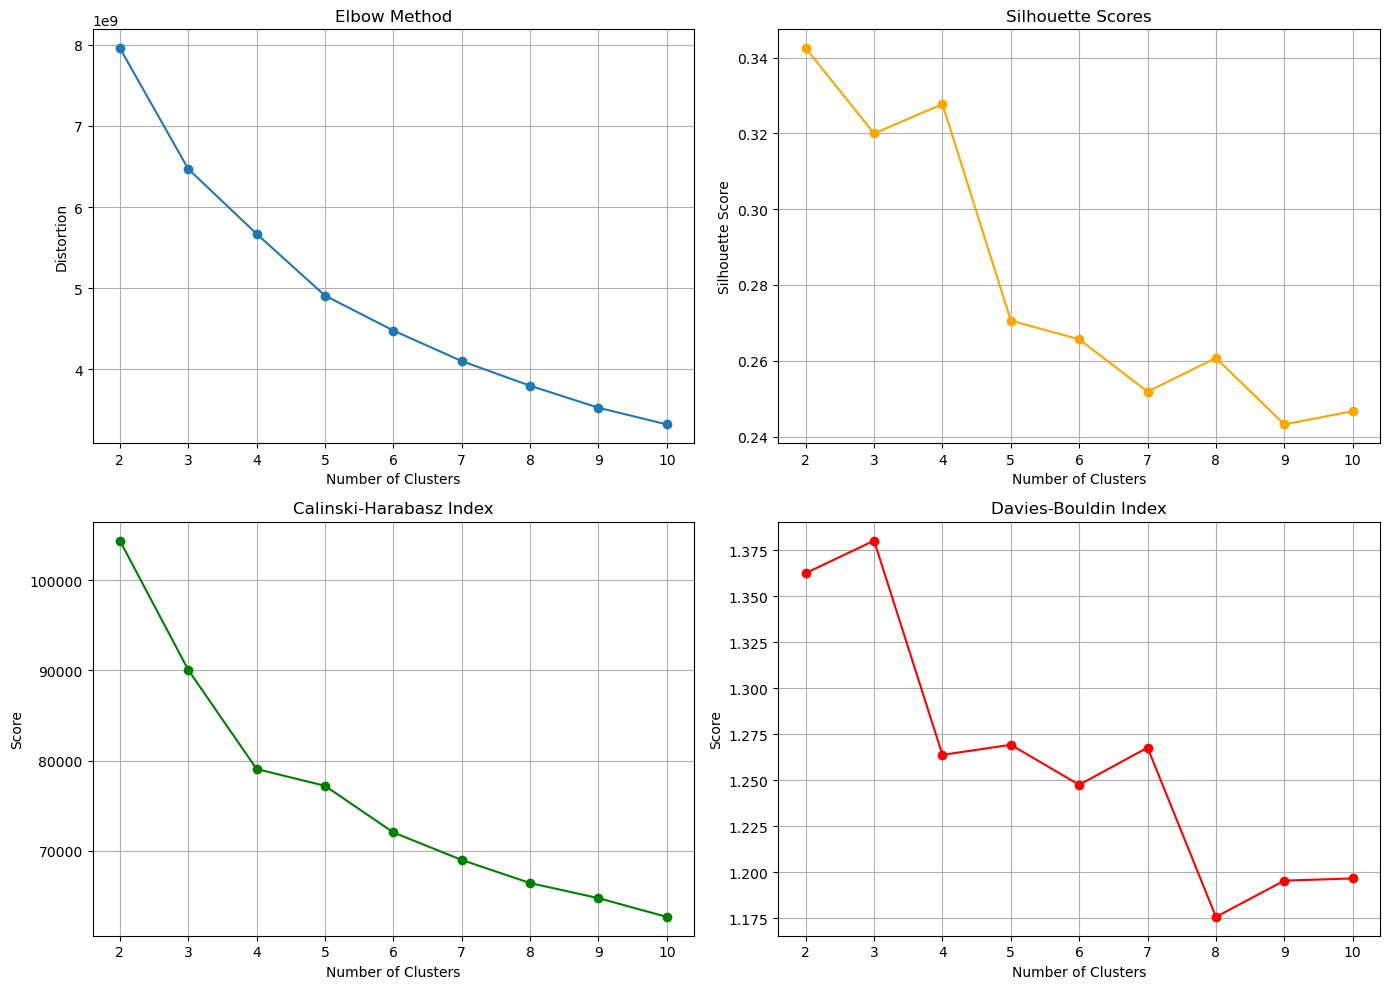

The best number of clusters based on Silhouette Score is: 2
The best number of clusters based on Calinski-Harabasz Index is: 2
The best number of clusters based on Davies-Bouldin Index is: 8


In [29]:
cluster_range, distortions, silhouette_scores, calinski_harabasz_scores, davies_bouldin_scores= evaluate_kmeans(X_transformed)
plot_kmeans(cluster_range, distortions, silhouette_scores, calinski_harabasz_scores, davies_bouldin_scores)
prev = prev+n_frames

/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


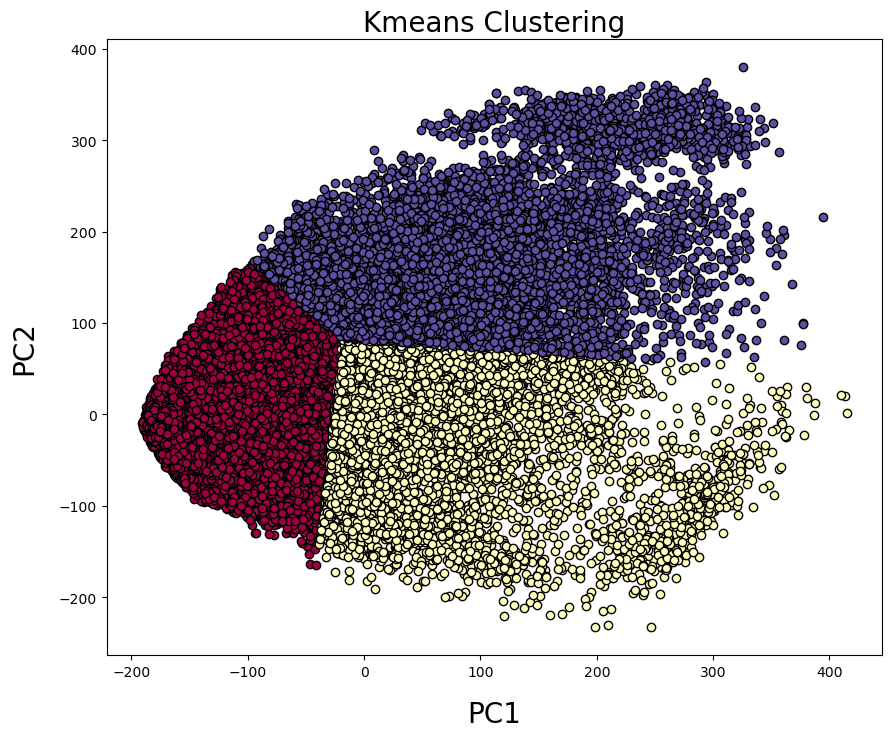

/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


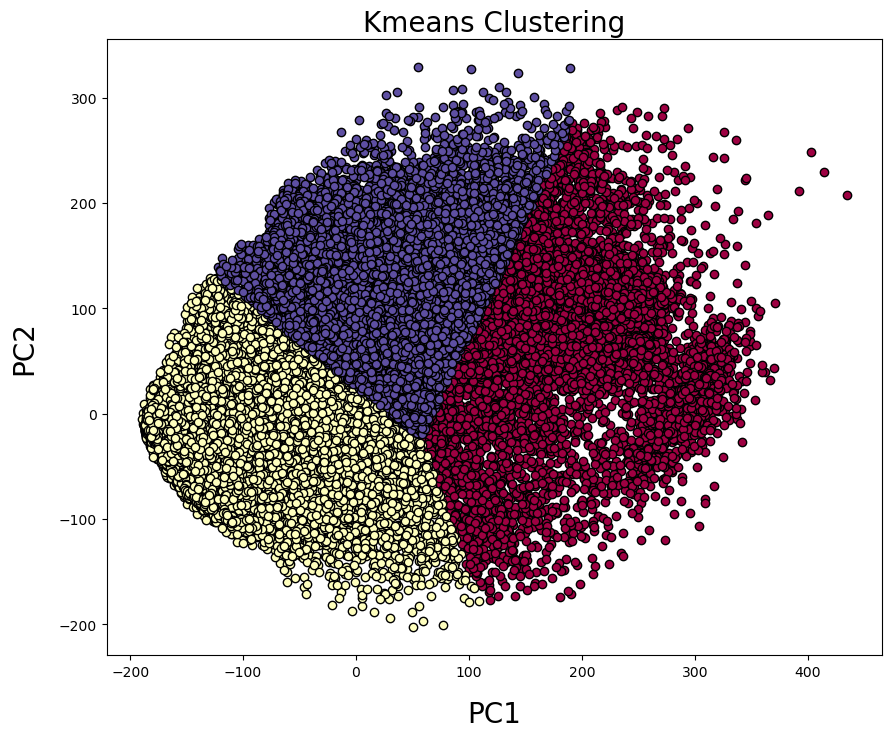

/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


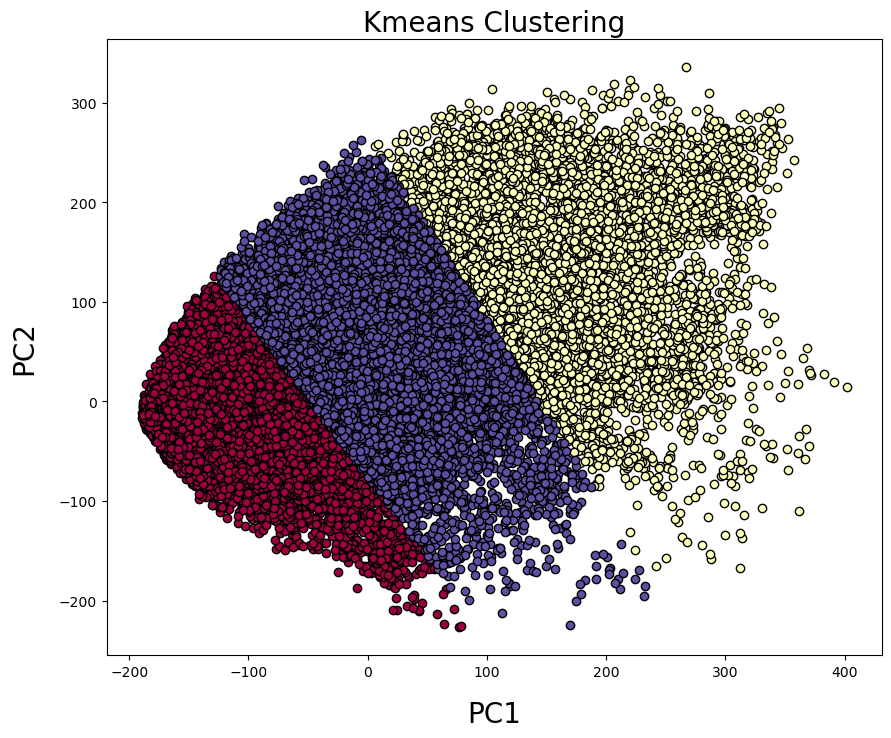

/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


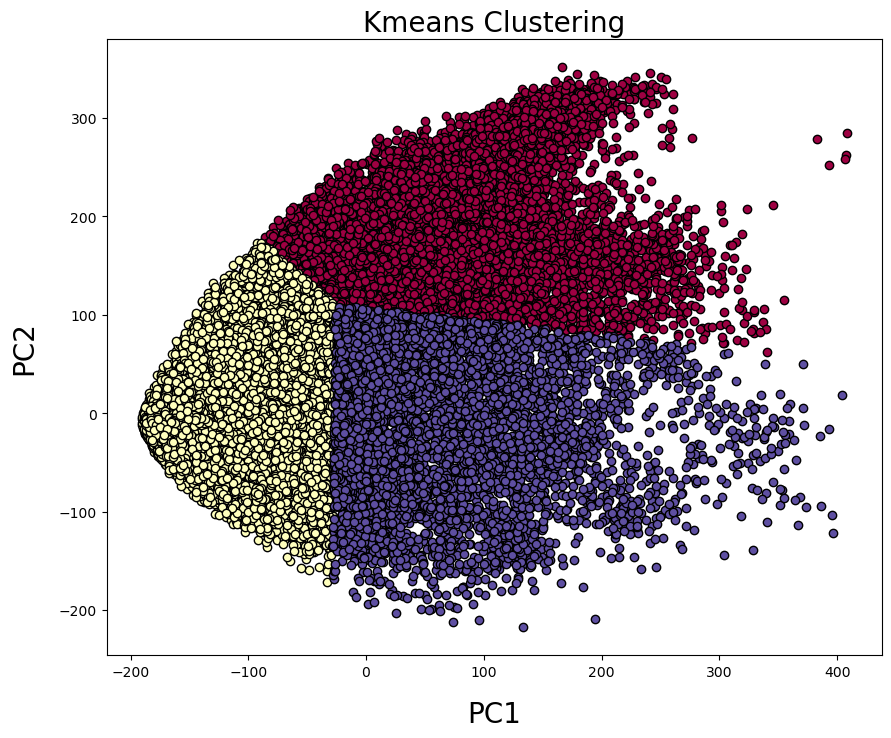

/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


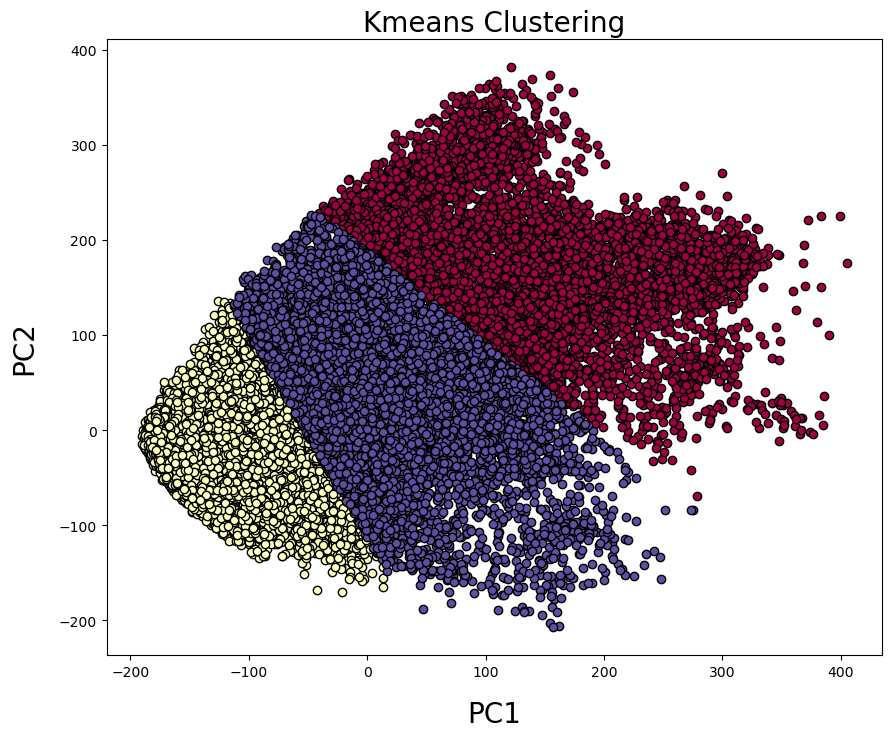

/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


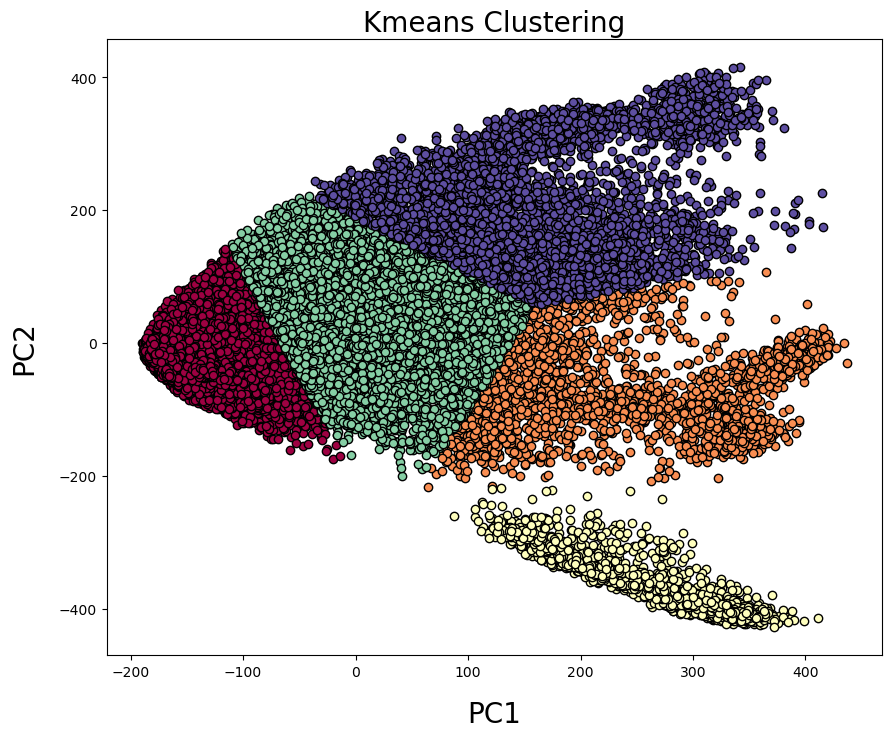

In [5]:
# run the kmeans algorithm on each of the trajectories with the 
num_clusters = [3, 3, 3, 3, 3, 5]
psystems= ["wt_hiapp_apo", "wt_hiapp_yxi1", "wt_hiapp_yxa1", "s20g_hiapp_apo", "s20g_hiapp_yxi1", "s20g_hiapp_yxa1"]
outdir = "/Users/f006j60/git/hIAPP_monomer_simulations/circuit_topology_incremental_PCA_outdir/" 
X_transformed= np.load("scripts/" + "all_sys_concat_incpca.npy")

prev = 0 
count = 0 
each_system_n_frames = [41501,43001,33723,35501, 35399, 35251 ]
for n_cluster, n_frames in zip(num_clusters, each_system_n_frames): 
    X = X_transformed[prev:prev+n_frames, :]
    x = X[:,0]
    y = X[:,1]

    ax, kmean_labels, centers = kmeans_cluster(x, y, clusters=n_cluster, title = "Kmeans Clustering")
    plt.show()
    
    # create a c_dict for each cluster  
    c_dict = {}
    for i in range(n_cluster):
        ind = np.where(kmean_labels==i)[0]
        c_dict[i] = np.array(ind).tolist()

# save this dictionary, so that the overall stats can be saved, while still being able to index the clusters 
    json_filename = outdir + psystems[count] +"_kmeans_cluster_indices.json"
    # Save as JSON
    with open(json_filename, 'w') as json_file:
        json.dump(c_dict, json_file)

# save the pc coordinates too 
    np.save(outdir + psystems[count] + "_incPCs.npy", np.column_stack((x,y)))
    prev = prev+n_frames
    count += 1

In [ ]:
jfile = outdir + "wt_hiapp_apo_kmeans_cluster_indices.json"
with open(jfile, "r") as file:
    data = json.load(file) 
data = {int(key): value for key, value in data.items()}